This Kernel for someone want to deep dive into image classification. I use CNN for classification model. If you found this Kernel helpful please up vote it. If you have some feedback and question don't forget to comment below. 

I have simplier model with 
* https://www.kaggle.com/uysimty/get-start-image-classification

# Import Library

In [38]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow import keras
print(os.listdir("input_2/"))


['training.csv', '.DS_Store', 'test', 'train', 'testing.csv']


# Define Constants

In [39]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Prepare Traning Data

In [40]:
filenames = os.listdir("input_2/train")
# categories = []
# for filename in filenames:
#     category = filename.split('.')[0]
#     if category == 'dog':
#         categories.append(1)
#     else:
#         categories.append(0)

# df = pd.DataFrame({
#     'filename': filenames,
#     'category': categories
# })

df = pd.read_csv('input_2/training.csv')

In [41]:
df.head()

,filename,category
0,gedebage1.jpg,1
1,gedebage2.jpg,1
2,gedebage3.jpg,1
3,gedebage4.jpg,1
4,gedebage5.jpg,1


In [42]:
df.shape

(474, 2)

### See Total In count

<AxesSubplot:>

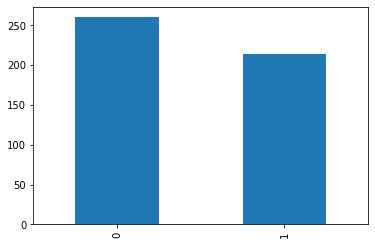

In [43]:
df['category'].value_counts().plot.bar()

In [44]:
df['category'].value_counts()

0    260
1    214
Name: category, dtype: int64

# See sample image

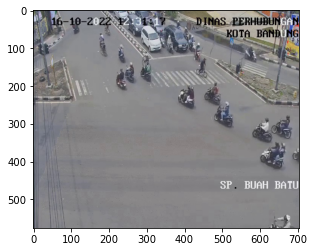

In [45]:
sample = random.choice(filenames)
image = load_img("input_2/train/"+sample)
plt.imshow(image)

# Build Model

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

In [46]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 61, 61, 64)      

# Callbacks

In [47]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [48]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [49]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [50]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to dog and 0 to cat

In [51]:
df["category"] = df["category"].replace({0: 'dry', 1: 'rain'}) 

In [58]:
train_df, validate_df = train_test_split(df, test_size=0.30, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

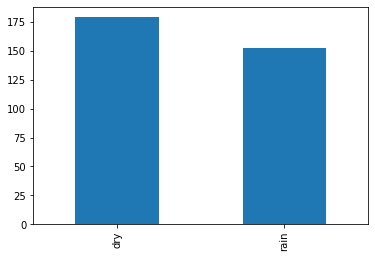

In [59]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

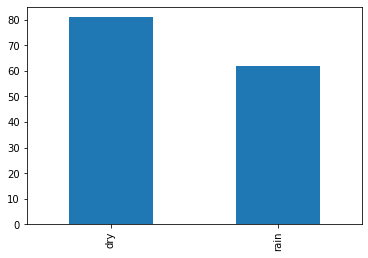

In [60]:
validate_df['category'].value_counts().plot.bar()

In [61]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning Generator

In [62]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "input_2/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 331 validated image filenames belonging to 2 classes.


### Validation Generator

In [63]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "input_2/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 143 validated image filenames belonging to 2 classes.


# See how our generator work

In [64]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "input_2/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


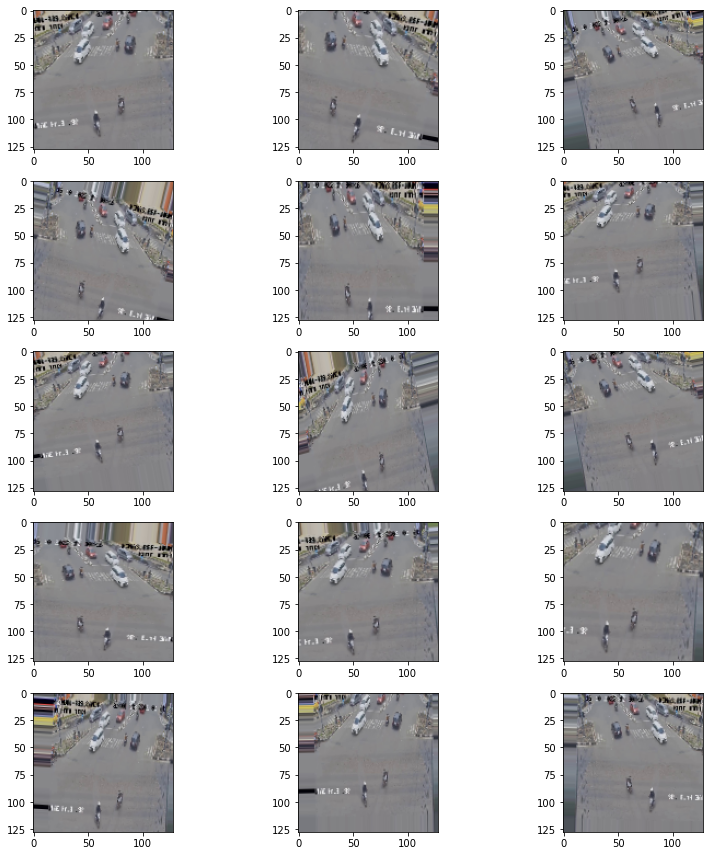

In [65]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice 

# Fit Model

In [66]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50


/var/folders/kk/1npl8ld13339b3w86z49mgj80000gp/T/ipykernel_26156/612699584.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


22/22 [==============================] - 9s 339ms/step - loss: 0.4742 - accuracy: 0.8734 - val_loss: 2.5787 - val_accuracy: 0.5704 - lr: 0.0010
Epoch 2/50
22/22 [==============================] - 7s 323ms/step - loss: 0.1180 - accuracy: 0.9430 - val_loss: 2.5717 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 0.1602 - accuracy: 0.9525
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
22/22 [==============================] - 7s 333ms/step - loss: 0.1602 - accuracy: 0.9525 - val_loss: 4.2729 - val_accuracy: 0.5630 - lr: 0.0010
Epoch 4/50
22/22 [==============================] - 7s 330ms/step - loss: 0.1057 - accuracy: 0.9652 - val_loss: 4.5053 - val_accuracy: 0.5556 - lr: 5.0000e-04
Epoch 5/50
22/22 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.9747
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
22/22 [==============================] - 7s 333ms/step - l

# Save Model

In [67]:
#model.save_weights("model.h5")
model.save('model_hujan.h5')

# Virtualize Training

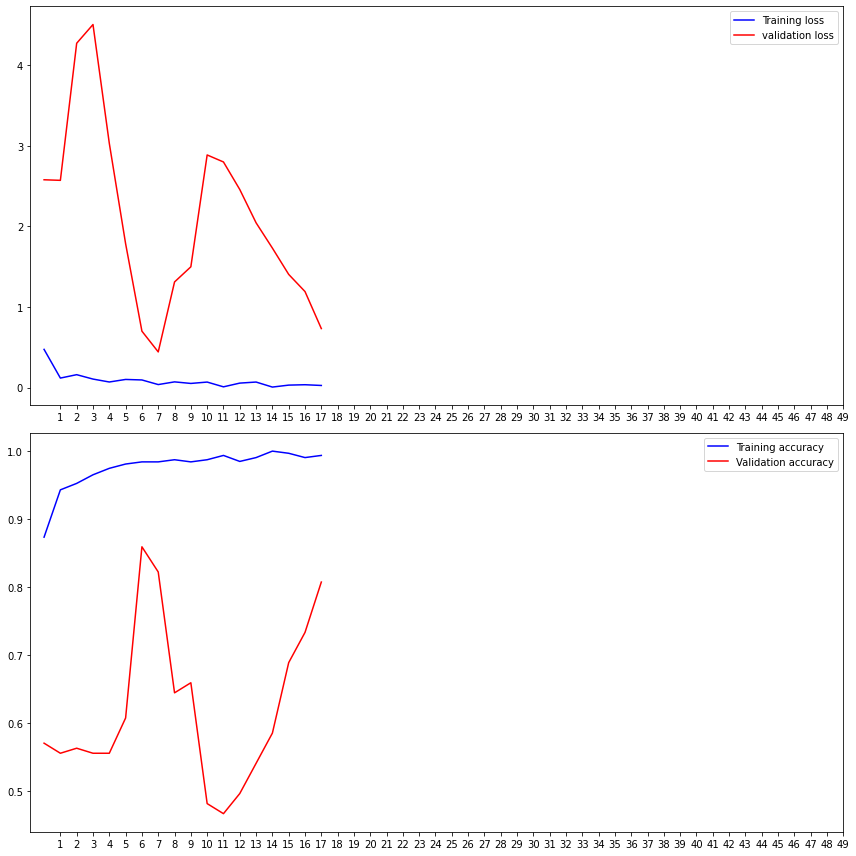

In [82]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.legend(loc="upper right")
# ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.legend(loc="upper right")

#legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [69]:
test_filenames = os.listdir("input_2/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [70]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "input_2/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 60 validated image filenames.


# Load Saved Model

In [71]:
model = keras.models.load_model('model_hujan.h5')

# Predict

In [72]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

/var/folders/kk/1npl8ld13339b3w86z49mgj80000gp/T/ipykernel_26156/3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [73]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [74]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with `{1: 'rain', 0: 'dry'}`. Now we will map the result back to dog is 1 and cat is 0

In [75]:
test_df['category'] = test_df['category'].replace({ 'rain': 1, 'dry': 0 })

### Virtaulize Result

<AxesSubplot:>

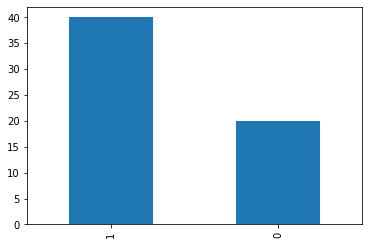

In [76]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

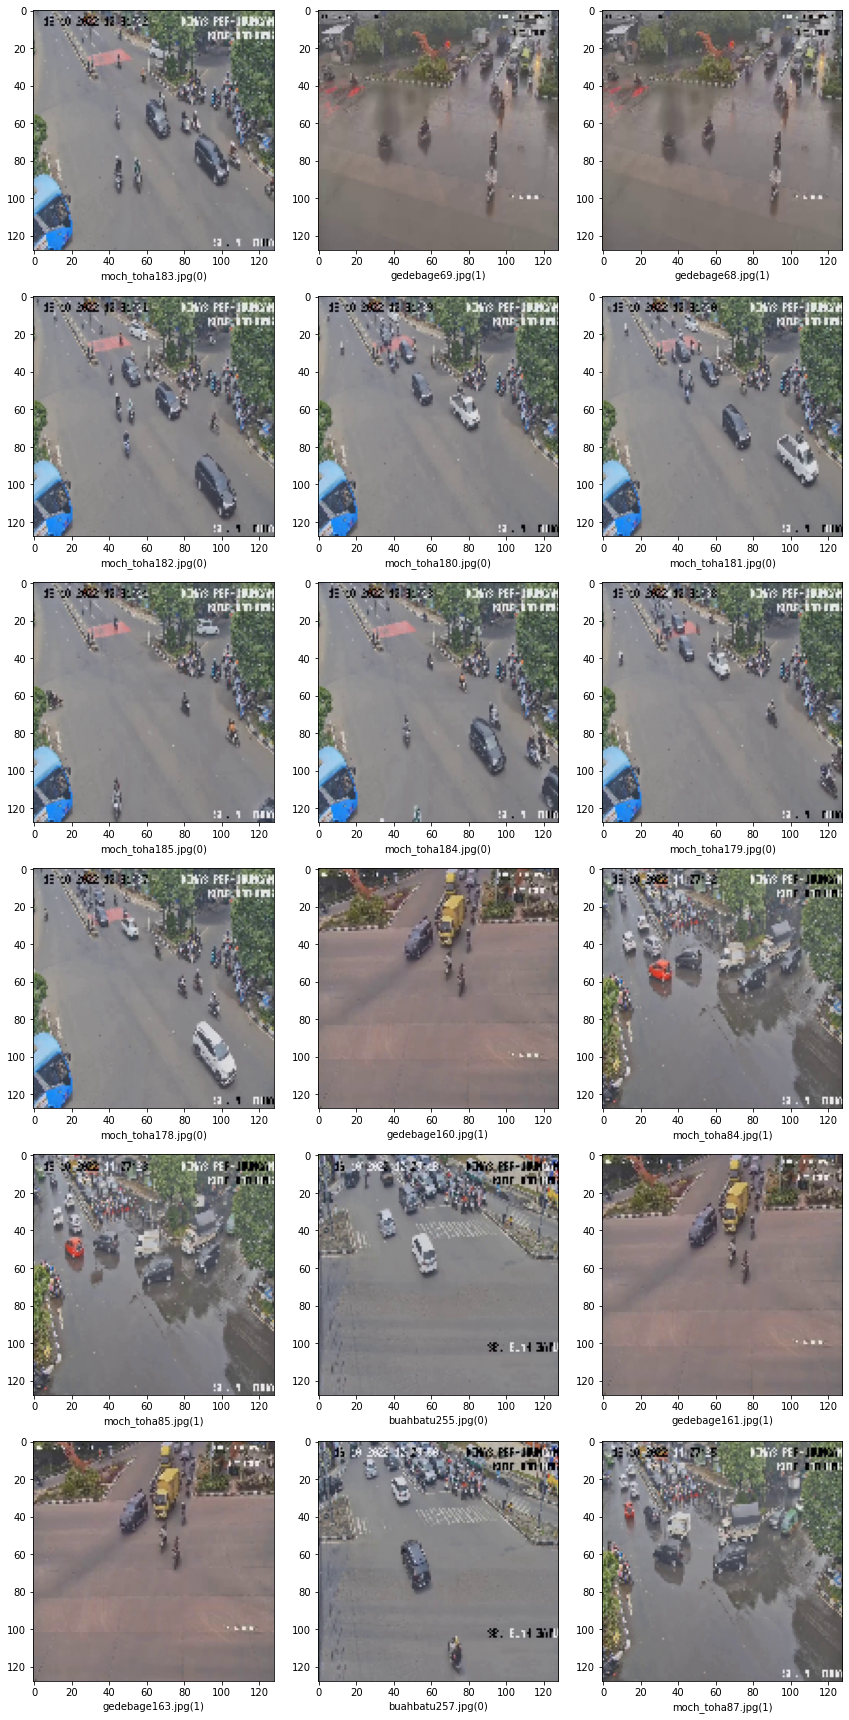

In [77]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("input_2/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [78]:
test_df_obs = pd.read_csv('input_2/testing.csv')
test_df_obs.columns = ['filename', 'category_obs']
test_df_obs.head()

,filename,category_obs
0,gedebage60.jpg,1
1,gedebage61.jpg,1
2,gedebage62.jpg,1
3,gedebage63.jpg,1
4,gedebage64.jpg,1


In [79]:
test_join = pd.merge(test_df_obs,test_df,left_on='filename',right_on='filename',how='left').rename(columns={'category':'category_pred'})
test_join

,filename,category_obs,category_pred
0,gedebage60.jpg,1,1
1,gedebage61.jpg,1,1
2,gedebage62.jpg,1,1
3,gedebage63.jpg,1,1
4,gedebage64.jpg,1,1
5,gedebage65.jpg,1,1
6,gedebage66.jpg,1,1
7,gedebage67.jpg,1,1
8,gedebage68.jpg,1,1
9,gedebage69.jpg,1,1


In [90]:
test_join.pivot_table(index='category_obs', columns='category_pred', 
                        aggfunc=len, fill_value=0)

filename    
category_pred        0   1
category_obs              
0                   20  10
1                    0  30

In [98]:
TN = test_join[(test_join['category_obs']==0) & (test_join['category_pred']==0)].shape[0]
FN = test_join[(test_join['category_obs']==1) & (test_join['category_pred']==0)].shape[0]
TP = test_join[(test_join['category_obs']==1) & (test_join['category_pred']==1)].shape[0]
FP = test_join[(test_join['category_obs']==0) & (test_join['category_pred']==1)].shape[0]

In [106]:
print("True Negative :",str(TN))
print("False Negative :",str(FN))
print("True Positive :",str(TP))
print("False Positive :",str(FP))
print("Precision :",str(TP/(TP+FP)))
print("Recall :",str(TP/(TP+FN)))
print("Accuracy :",str((TP+TN)/(TP+FP+TN+FN)))
print("F1 Score :",str((2*(TP/(TP+FP))*(TP/(TP+FN)))/((TP/(TP+FP))+(TP/(TP+FN)))))
print("Specificity :",str(TN/(TN+FP)))

True Negative : 20
False Negative : 0
True Positive : 30
False Positive : 10
Precision : 0.75
Recall : 1.0
Accuracy : 0.8333333333333334
F1 Score : 0.8571428571428571
Specificity : 0.6666666666666666


**Accuracy :**
Merupakan rasio prediksi Benar (positif dan negatif) dengan keseluruhan data. Akurasi menjawab pertanyaan “Berapa persen kejadian yang benar diprediksi hujan dan tidak hujan dari kesuluruhan kejadian”

<br></br>
**Precission :**

Merupakan rasio prediksi benar positif dibandingkan dengan keseluruhan hasil yang diprediksi positf. Precission menjawab pertanyaan “Berapa persen kejadian yang benar hujan dari keseluruhan kejadian yang diprediksi hujan?”

<br></br>
**Recall (Sensitifitas) :**

Merupakan rasio prediksi benar positif dibandingkan dengan keseluruhan data yang benar positif. Recall menjawab pertanyaan “Berapa persen kejadian yang diprediksi hujan dibandingkan keseluruhan kejadian yang sebenarnya hujan”.

<br></br>
**Specificity :**

Merupakan kebenaran memprediksi negatif dibandingkan dengan keseluruhan data negatif. Specificity menjawab pertanyaan “Berapa persen kejadian yang benar diprediksi tidak hujan dibandingkan dengan keseluruhan kejadian yang sebenarnya tidak hujan”.

<br></br>
**F1 Score :**

F1 Score merupakan perbandingan rata-rata presisi dan recall yang dibobotkan

F1 Score = 2 * (Recall*Precission) / (Recall + Precission).

# Submission

In [ ]:
# submission_df = test_df.copy()
# submission_df['id'] = submission_df['filename'].str.split('.').str[0]
# submission_df['label'] = submission_df['category']
# submission_df.drop(['filename', 'category'], axis=1, inplace=True)
# submission_df.to_csv('submission.csv', index=False)